In [1]:
import os
import numpy as np
import gym
import stable_baselines3
from fmi_mlc import fmi_gym, fmi_gym_parameter
from parameters import parameter as PARAMS
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/opt/conda/envs/conda_environment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")           # elimina tutti i warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
PARAMS

{'seed': 1,
 'store_data': True,
 'fmu_step_size': 600.0,
 'fmu_path': 'lab_building_external_control.fmu',
 'fmu_start_time': 0,
 'fmu_warmup_time': 0,
 'fmu_final_time': 2678400,
 'action_names': ['Kitchen_shade_FMU',
  'Bath_shade_1_FMU',
  'Room1_shade_1_FMU',
  'Room1_shade_2_FMU',
  'Bath2_Shade_FMU',
  'Living_shade_1_FMU',
  'Living_shade_2_FMU',
  'Room2_shade1_FMU',
  'Room2_shade_2_FMU'],
 'action_min': array([-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000.]),
 'action_max': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]),
 'observation_names': ['Tin_Kitchen',
  'Tin_Bathroom1',
  'Tin_Room1',
  'Tin_Corridor',
  'Tin_Room',
  'Tin_Linvingroom',
  'T_out',
  'DNI',
  'DistrictHeating',
  'DistrictCooling',
  'Electricity',
  'Tin_Bathroom',
  'Room_shade2',
  'Room_shade1',
  'Bathroom1_shade',
  'Room1_shade1',
  'Room1_shade2',
  'Bathroom_shade1',
  'Living_shade2',
  'Living_shade1'],
 'reward_names': []}

In [ ]:
PARAMS['hidden_observation_names'] = ['EL_Energy']
PARAMS['observation_names'].remove('EL_Energy')

In [ ]:
class ComfortEnergyPostProcessor:
    """
    Post-processor used in FMI-MLC for computing the reward related to shading devices.

    Final reward logic:
        IF DNI < 1:
            reward = 0                      # no solar radiation → shading has no effect
        ELSE:
            reward = -(comfort_pen + energy_pen)

    Where:
        comfort_pen = sum over all Tin_* zones of (d)^2
        d = distance from comfort band [Th, Tc]:
            Tin < Th → d = Th - Tin
            Tin > Tc → d = Tin - Tc
            inside band → d = 0

        energy_pen = lambda_energy * (DistrictHeating / COP_H + DistrictCooling / EER_C)

    NOTES:
    - Use ONLY variables received from the FMU via From:Variable.
    - Comfort band thresholds Th/Tc are defined here (hardcoded).
    - The logic works the same for summer/winter; just change Th/Tc if needed.
    """

    def __init__(self, p):
        self.p = p

        # Comfort band limits (°C)
        # Temperatures below Th are considered too cold; above Tc too warm.
        self.Th = 20.0        # lower comfort threshold (heating setpoint)
        self.Tc = 25.0        # upper comfort threshold (cooling setpoint)

        # Optional normalization factor for comfort deviation
        self.dT_tol = 1.0

        # Weight applied to the total energy consumption term
        # Must be tuned empirically depending on magnitude of energy signals.
        self.lambda_energy = 1e-6 # because energy is a high number

    def do_calc(self, data, init):
        # ---------------------------------------------------------------------
        # 1) READ SOLAR RADIATION (DNI)
        #    Shading only matters when solar radiation is present.
        # ---------------------------------------------------------------------
        try:
            dni_val = float(data["DNI"].values[0])
        except KeyError:
            # If DNI is not exported from the FMU, the reward cannot be computed correctly
            raise RuntimeError("DNI was not exported from the FMU (From:Variable).")

        # ---------------------------------------------------------------------
        # 2) NO RADIATION → REWARD = 0
        #    If DNI < 1 W/m², we assume shading has no effect.
        #    Reward is neutral to avoid biasing the RL agent.
        # ---------------------------------------------------------------------
        if dni_val < 1.0:
            data["reward"] = 0.0
            return data

        # ---------------------------------------------------------------------
        # 3) COMFORT PENALTY CALCULATION (only when radiation is present)
        #    Iterate over all indoor temperature signals Tin_*.
        #    For each zone compute the squared deviation from the comfort band.
        # ---------------------------------------------------------------------
        comfort_pen = 0.0

        # Identify columns starting with "Tin_"
        tin_cols = [c for c in data.columns if c.startswith("Tin_")]

        for col in tin_cols:
            Tin = data[col]  # Single-row Series representing the zone temperature

            # Distance from comfort band:
            # - If Tin < Th → too cold → deviation = Th - Tin
            # - If Tin > Tc → too hot  → deviation = Tin - Tc
            # - Otherwise → inside comfort band → deviation = 0
            d = np.where(
                Tin < self.Th,
                self.Th - Tin,             # cold discomfort
                np.where(
                    Tin > self.Tc,
                    Tin - self.Tc,          # heat discomfort
                    0.0                     # comfortable range
                )
            )

            # Quadratic penalty (standard in comfort evaluation)
            # d is normalized by dT_tol before squaring
            comfort_pen += (d / self.dT_tol)**2

        # ---------------------------------------------------------------------
        # 4) HEATING/COOLING LOADS PENALTY CALCULATION
        #    Reads heating and cooling load values directly from the FMU.
        #    Units are expected to be Joules for the current timestep.
        # ---------------------------------------------------------------------
        try:
            Eh = float(data["DH_Energy"].values[0])     # heating energy [J]
            Ec = float(data["DC_Energy"].values[0])     # cooling energy [J]
        except KeyError as e:
            # If any of these variables is missing, we cannot compute the energy term
            raise RuntimeError(f"Energy variable missing in the FMU: {e}")
        
        # Convert to Final Energy to sum the loads
        COP_H = 0.98
        EER_C = 5.4

        E_final = abs(Eh) / COP_H + abs(Ec) / EER_C
        
        # Weighted energy penalty
        energy_pen = self.lambda_energy * E_final

        # ---------------------------------------------------------------------
        # 5) FINAL REWARD
        #    Negative value: RL agent tries to minimize discomfort + heating/cooling loads.
        # ---------------------------------------------------------------------
        data["reward"] = - (comfort_pen + energy_pen)

        return data


In [ ]:
PARAMS['postprocessor'] = ComfortEnergyPostProcessor

In [7]:
class SB3Wrapper(gym.Wrapper):
    """
    SB3Wrapper around an existing fmi_gym environment.

    Semantics:

    - RL episode: fixed duration in hours (episode_hours, e.g. 48h).
    - Physical FMI episode: runs from the initial time up to fmu_final_time.
    - reset of fmi_mlc (env.reset()) is called ONLY when
      the physical simulation has finished (done_env == True).

    - If ONLY the RL episode ends (e.g. 2 days) but the physical simulation continues:
        * we return done=True to the agent (end of RL episode)
        * we DO NOT call env.reset()
        * the FMU continues from its current physical state
        * the next RL episode starts from the same observation (last_obs)
          and continues the same physical trajectory.

    - Action space:
        * SB3 sees MultiDiscrete([2] * N_shades)
        * 0 -> 0.0, 1 -> 7.0
        * N_shades = len(env.parameter["action_names"])
          (one discrete action per shading device)

    - Observation space: identical to that of the wrapped fmi_gym environment.
    """

    def __init__(self, env: fmi_gym, episode_hours: float = 48.0):
        # env is already a configured fmi_gym environment
        super().__init__(env)

        # Keep a direct alias for clarity
        self.base_env = env

        # ----- Action space: MultiDiscrete [0, 1] for each FMI action -----
        # We read the list of action names from the fmi_gym parameters
        self.action_names = self.base_env.parameter["action_names"]
        self.n_actions = len(self.action_names)

        # Each action can be 0 or 1; SB3 sees this as a MultiDiscrete space
        self.action_space = spaces.MultiDiscrete([2] * self.n_actions)

        # ----- Observation space: identical to FMI-MLC / fmi_gym -----
        self.observation_space = self.base_env.observation_space

        # ----- RL episodes: duration expressed in number of steps -----
        self.episode_hours = episode_hours
        self.dt = self.base_env.parameter["fmu_step_size"]  # [s] FMU time step

        # Compute maximum number of RL steps per episode:
        # episode_hours [h] → seconds, then divide by FMU step size dt [s].
        self.max_steps_per_episode = int(
            (self.episode_hours * 3600.0) / self.dt
        )

        # Internal wrapper state
        self.rl_steps = 0          # number of RL steps in the current episode
        self.env_done = False      # True if fmi_gym reported end of physical simulation
        self.last_obs = None       # last observation returned to the agent

    # ------------------------------------------------------------------
    # RESET
    # ------------------------------------------------------------------
    def reset(self, **kwargs):
        """
        Reset from the agent's point of view (RL episode reset).

        Behavior:

        - If the physical simulation is NOT finished (env_done == False):
             -> DO NOT call env.reset()
             -> DO NOT touch the FMU state
             -> only reset the RL step counter and
                return the last observation (last_obs).
                This starts a new RL episode over the same physical trajectory.

        - If the physical simulation IS finished (env_done == True):
             -> call env.reset() ONCE (true FMU reset)
             -> reset env_done and rl_steps
             -> return the new initial observation from the environment.

        Notes:
        - On the VERY first call, last_obs is None, so we must reset the base
          environment to obtain the initial observation.
        """

        # Case 1: very first reset call, no previous observation exists yet
        if self.last_obs is None:
            obs = self.base_env.reset()
            self.rl_steps = 0
            self.env_done = False
            self.last_obs = obs
            return obs

        # Case 2: physical simulation NOT finished -> logical RL reset only
        if not self.env_done:
            # Do not touch the FMU: the new RL episode starts from the last
            # physical state and observation already computed.
            self.rl_steps = 0
            return self.last_obs

        # Case 3: physical simulation FINISHED -> true FMI-MLC reset
        obs = self.base_env.reset()
        self.rl_steps = 0
        self.env_done = False
        self.last_obs = obs
        return obs

    # ------------------------------------------------------------------
    # STEP
    # ------------------------------------------------------------------
    def step(self, action):
        """
        RL step wrapper.

        - action: MultiDiscrete[0..1]^N_shades as seen by SB3.

        - Mapping from SB3 discrete action to FMU continuous action:
              0 -> 0.0
              1 -> 7.0
          applied element-wise to each shading device/action.

        - The mapped action is passed to fmi_gym.step().

        - Internal counters:
            * rl_steps is incremented every time step() is called.
            * env_done stores whether the underlying physical simulation has ended.

        - done_rl (the 'done' returned to SB3) is True if:
            * we reached the RL episode duration in steps
              (rl_steps >= max_steps_per_episode), OR
            * the physical simulation (fmi_gym) signaled done_env == True.

          In the first case only (RL episode ends but env_done == False),
          the FMU continues from its current state and the next reset()
          will just restart the RL episode logically from last_obs.
        """

        # Convert the MultiDiscrete action into a NumPy array of ints
        action = np.asarray(action, dtype=int)

        # Map discrete {0, 1} actions to continuous {0.0, 7.0} values for the FMU
        fmi_action = np.where(action == 0, 0.0, 7.0)

        # Delegate the step to the underlying fmi_gym environment
        obs, reward, done_env, info = self.base_env.step(fmi_action)

        # Update internal state with the latest observation and physical done flag
        self.last_obs = obs
        self.env_done = bool(done_env)

        # Increase RL step counter for the current RL episode
        self.rl_steps += 1

        # RL episode termination:
        # - either we reached the maximum number of steps for this episode
        # - or the underlying physical simulation has ended
        done_rl = (self.rl_steps >= self.max_steps_per_episode) or self.env_done

        # Return the observation, reward, RL done flag, and info dict
        return obs, reward, done_rl, info



In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class EpisodeStatsCallback(BaseCallback):
    """
    Custom callback to collect per-episode statistics during training with Stable-Baselines3.

    What it stores:
    - episode_returns : list of total rewards per episode (sum of step rewards)
    - episode_lengths : list of episode lengths in number of environment steps
    - episode_metrics : list of dicts, each containing ALL logged train/* metrics
                        at the end of each episode (e.g., losses, entropy, etc.)

    Notes:
    - Works with both single and vectorized environments (n_envs >= 1).
    - For vectorized envs, it tracks cumulative returns and lengths separately
      for each environment index.
    """

    def __init__(self, verbose=0):
        """
        Constructor.

        :param verbose: verbosity level (0 = silent, >0 prints episode summaries).
        """
        super().__init__(verbose)

        # Total return (sum of rewards) per completed episode
        self.episode_returns = []

        # Length in steps per completed episode
        self.episode_lengths = []

        # Here we store ALL metrics logged by the SB3 logger (only train/*),
        # one dict per completed episode.
        self.episode_metrics = []  # <--- here we store ALL metrics

    def _on_training_start(self):
        """
        Called once at the beginning of training.

        Initializes per-environment accumulators:
        - _ep_ret: cumulative reward for the current ongoing episode in each env
        - _ep_len: number of steps taken in the current ongoing episode in each env
        """
        # Number of parallel environments (1 for non-vectorized envs)
        n_envs = getattr(self.training_env, "num_envs", 1)

        # Cumulative reward per environment (current episode)
        self._ep_ret = np.zeros(n_envs)

        # Number of steps per environment (current episode)
        self._ep_len = np.zeros(n_envs, dtype=int)

    def _on_step(self):
        """
        Called at every environment step.

        Responsibilities:
        - Read rewards and done flags for each environment.
        - Accumulate episode return and length for each env index.
        - When an episode ends (done=True for that env):
            * store total return and length in the public lists
            * extract ALL train/* metrics from the SB3 logger
              and store them in episode_metrics
            * optionally print a summary if verbose > 0
            * reset per-episode accumulators for that env index
        """

        # Get rewards and done flags from the locals dict.
        # SB3 can use either "rewards"/"dones" or "reward"/"done"
        rewards = np.atleast_1d(self.locals.get("rewards", self.locals.get("reward")))
        dones   = np.atleast_1d(self.locals.get("dones",   self.locals.get("done")))

        # Iterate over each environment in the vectorized setup
        for i, (r, d) in enumerate(zip(rewards, dones)):
            # Accumulate reward and step count for the current episode of env i
            self._ep_ret[i] += float(r)
            self._ep_len[i] += 1

            # If the environment signals the end of an episode
            if d:
                # Final return and length for the completed episode in env i
                R = float(self._ep_ret[i])
                L = int(self._ep_len[i])

                # Store episode-level stats
                self.episode_returns.append(R)
                self.episode_lengths.append(L)

                # Access all logged metrics from the SB3 logger
                metrics = self.model.logger.name_to_value

                # Extract ALL metrics whose key starts with "train/"
                # and strip the "train/" prefix from the keys.
                ep_m = {
                    k.replace("train/", ""): v
                    for k, v in metrics.items()
                    if k.startswith("train/")
                }
                self.episode_metrics.append(ep_m)

                # Optional console output
                if self.verbose:
                    print(
                        f"[Episode {len(self.episode_returns)}] "
                        f"R={R:.2f}, len={L}, metrics={ep_m}"
                    )

                # Reset accumulators for this environment index
                self._ep_ret[i] = 0.0
                self._ep_len[i] = 0

        # Returning True tells SB3 to continue training
        return True

In [9]:
from stable_baselines3.common.callbacks import BaseCallback
from tqdm.auto import tqdm  # make sure `tqdm` is installed
import sys

class TqdmProgressCallback(BaseCallback):
    """
    Callback that displays a live tqdm progress bar during SB3 training.

    Purpose:
    --------
    Stable-Baselines3 normally prints periodic logs, but does not provide
    a continuous progress bar. This callback fills that gap by showing a
    clean tqdm progress bar that updates in-place without producing new lines.

    How it works:
    -------------
    - At the beginning of training, a tqdm bar is created with `total_timesteps`.
    - At every call to `_on_step()`, we compute how many timesteps have passed
      since the last update and increment the bar by that delta.
      (This avoids unnecessary redraws and prevents line flooding.)
    - At the end of training, the bar is forced to completion and closed.

    Notes:
    ------
    - Uses `sys.stdout` to ensure correct behavior inside Jupyter notebooks
      and terminal environments.
    - `leave=False` ensures the bar disappears after completion rather than
      leaving a residual printed line.
    """

    def __init__(self, total_timesteps):
        """
        :param total_timesteps: the total number of agent training timesteps,
                                typically the same value passed to model.learn().
        """
        super().__init__()
        self.total_timesteps = total_timesteps
        self.pbar = None       # tqdm progress bar object
        self._last = 0         # last timestep count used to compute incremental updates

    def _on_training_start(self):
        """
        Called once at the beginning of training.

        Initializes the tqdm progress bar. The bar dynamically adapts its width
        to the terminal/notebook and updates smoothly without extra lines.
        """
        self.pbar = tqdm(
            total=self.total_timesteps,
            desc="Training",
            leave=False,          # do not leave a new line after completion
            file=sys.stdout,      # ensures proper display in notebook and terminal
            mininterval=0.1,      # minimum time between updates
            dynamic_ncols=True,   # adjust to terminal width
        )

    def _on_step(self):
        """
        Called at every environment step.

        We update the progress bar ONLY by the number of newly completed
        timesteps, to avoid unnecessary redraws.

        SB3 provides `self.num_timesteps`, which is the global count of steps
        since training started. We store the previous value in `self._last` to
        compute the delta.
        """
        delta = self.num_timesteps - self._last

        if delta > 0:
            self.pbar.update(delta)
            self._last = self.num_timesteps

        return True  # continue training

    def _on_training_end(self):
        """
        Called once at the end of training.

        Ensures the progress bar reaches 100% and then closes it cleanly.
        """
        # Force completion if not already full
        self.pbar.update(self.total_timesteps - self._last)
        self.pbar.close()


In [10]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import CallbackList, ProgressBarCallback

# 1) FMI-MLC parameters
#    Here we configure the FMU simulation time window and behavior.

# Example:
PARAMS["fmu_start_time"] = 185 * 24 * 3600   # start day of year (in seconds) → day 185
PARAMS["fmu_final_time"] = 220 * 24 * 3600   # end day of year (in seconds) → day 220

# If False: the physical simulation is allowed to reset between episodes
# (this can interact with ignore_reset logic inside your fmi_gym / FMU wrapper).
PARAMS["ignore_reset"] = False               # physical simulation does NOT continue between episodes unconditionally

# FMU log level (0 = silent / minimal logging, higher = more verbose)
PARAMS["fmu-loglevel"] = 0

# 2) Create base FMI-MLC environment
#    fmi_gym is assumed to be a custom gym.Env that wraps the FMU.
base_env = fmi_gym(parameter=PARAMS)

# 3) Wrap with SB3Wrapper to:
#    - expose a MultiDiscrete action space for the blinds/shades
#    - handle RL episode length vs physical simulation length
env = SB3Wrapper(base_env)


In [ ]:
model = A2C(
    "MlpPolicy",
    env,
    gamma=0.997

)
total_timesteps = 500_000

In [ ]:
metrics_cb = EpisodeStatsCallback(verbose=0)
progress_cb = TqdmProgressCallback(total_timesteps=total_timesteps)
callback = CallbackList([progress_cb, metrics_cb])

model.learn(
    total_timesteps=total_timesteps,
    callback=callback,
    progress_bar=False,  # DISATTIVA la barra interna SB3
)

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47859.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47859.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmptbf97zjr//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmptbf97zjr//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 08:55
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36851.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36851.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp2_ftt_3t//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 08:56
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:   2%|▏         | 10100/500000 [01:50<16:46:30,  8.11it/s]

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34689.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34689.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpot5c0omg//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:   3%|▎         | 12956/500000 [02:18<1:21:20, 99.80it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   3%|▎         | 15114/500000 [02:44<1:17:25, 104.37it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.09sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmppcjcznla//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 08:58
Initializing Response Factors
Calculating

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41809.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41809.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmppcjcznla//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   4%|▎         | 17989/500000 [03:18<1:17:39, 103.44it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   4%|▍         | 20156/500000 [03:44<1:38:45, 80.98it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.90sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpyej313g6//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 08:59
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40277.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40277.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpyej313g6//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   5%|▍         | 23037/500000 [04:18<1:12:28, 109.70it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   5%|▌         | 25195/500000 [04:44<1:25:37, 92.43it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.51sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.62sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpf86uonn_//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:00
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39375.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39375.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpf86uonn_//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   6%|▌         | 28069/500000 [05:21<1:16:27, 102.88it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   6%|▌         | 30239/500000 [05:45<1:25:24, 91.67it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 54.75sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpj81see58//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:01
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38785.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38785.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpj81see58//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   7%|▋         | 33117/500000 [06:18<1:16:10, 102.16it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   7%|▋         | 35278/500000 [06:40<1:13:29, 105.38it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 51.10sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpr5bjixxn//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day o

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



ylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 WINTER DESIGN DAY
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
Number of outputs in ExternalInterface = 20
Number of inputs  in ExternalInterface = 9
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45465.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45465.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpr5bjixxn//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   8%|▊         | 38160/500000 [07:15<1:10:32, 109.12it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   8%|▊         | 40317/500000 [07:37<1:17:34, 98.76it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.17sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmph_rrbj8z//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Number of outputs in ExternalInterface = 20
Number of inputs  in ExternalInterface = 9
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:   8%|▊         | 40338/500000 [07:43<15:29:47,  8.24it/s]

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35945.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35945.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmph_rrbj8z//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:   9%|▊         | 43198/500000 [08:13<38:12, 199.25it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   9%|▉         | 45358/500000 [08:36<1:20:32, 94.08it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 54.07sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpnin9vw_s//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:04
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36507.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36507.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpnin9vw_s//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  10%|▉         | 48231/500000 [09:17<1:21:21, 92.54it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  10%|█         | 50393/500000 [09:43<1:16:27, 98.00it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.45sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  3.07sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmphewj5a9g//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:05
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37831.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37831.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmphewj5a9g//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  11%|█         | 53276/500000 [10:21<1:10:51, 105.08it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  11%|█         | 55430/500000 [10:45<1:45:14, 70.41it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.77sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50287.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50287.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpt_qhs5y4//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:06
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpt_qhs5y4//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  12%|█▏        | 58318/500000 [11:22<1:21:56, 89.83it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  12%|█▏        | 60471/500000 [11:48<1:35:27, 76.74it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.93sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpz7gxev2h//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:07
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56435.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56435.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpz7gxev2h//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  13%|█▎        | 63356/500000 [12:23<1:10:19, 103.48it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  13%|█▎        | 65519/500000 [12:44<1:07:14, 107.68it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.41sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.18sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 51.57sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzh4cbipc//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day o

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 43885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 43885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzh4cbipc//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  14%|█▎        | 68399/500000 [13:18<1:18:42, 91.40it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  14%|█▍        | 70554/500000 [13:39<1:11:03, 100.74it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 50.79sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40183.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40183.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpv7082a8p//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:09
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpv7082a8p//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  15%|█▍        | 73434/500000 [14:13<1:11:56, 98.82it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  15%|█▌        | 75591/500000 [14:36<1:11:36, 98.79it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.36sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp5zqcqs64//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Number of outputs in ExternalInterface = 20
Number of inputs  in ExternalInterface = 9
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:  15%|█▌        | 75612/500000 [14:42<15:07:52,  7.79it/s]

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 43295.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 43295.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp5zqcqs64//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  16%|█▌        | 78480/500000 [15:11<1:01:42, 113.85it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  16%|█▌        | 80637/500000 [15:33<1:15:33, 92.51it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.21sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.55sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmph9kmlevm//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:11
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53939.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53939.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmph9kmlevm//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  17%|█▋        | 83520/500000 [16:16<1:13:20, 94.64it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  17%|█▋        | 85671/500000 [16:40<1:20:03, 86.26it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.50sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38559.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38559.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpxlaw414u//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:12
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpxlaw414u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  18%|█▊        | 88552/500000 [17:19<1:02:44, 109.31it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  18%|█▊        | 90716/500000 [17:40<1:09:26, 98.22it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.34sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.02sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpepj1kh6u//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50695.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50695.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpepj1kh6u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  19%|█▊        | 93593/500000 [18:18<1:26:31, 78.28it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  19%|█▉        | 95758/500000 [18:39<59:12, 113.78it/s]  Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.55sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmppceyfjnt//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:14
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51099.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51099.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmppceyfjnt//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  20%|█▉        | 98613/500000 [19:23<19:16, 347.03it/s] Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  20%|██        | 100784/500000 [19:53<1:00:33, 109.89it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  9.27sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpy0wbkbq3//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:15
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50161.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50161.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpy0wbkbq3//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  21%|██        | 103671/500000 [20:31<1:04:46, 101.98it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  21%|██        | 105831/500000 [20:54<1:07:39, 97.10it/s] Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.50sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.94sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpp2kwnd2j//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:16
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpp2kwnd2j//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  22%|██▏       | 108714/500000 [21:35<1:06:15, 98.42it/s] Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  22%|██▏       | 110875/500000 [22:02<1:51:33, 58.14it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.51sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  0.99sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46431.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46431.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp6uqe0fr9//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:17
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48331.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48331.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.81sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpb3ch2yor//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:18
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpuv0iz0e1//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:19
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50591.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50591.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpuv0iz0e1//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  25%|██▍       | 123839/500000 [24:41<56:03, 111.84it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  25%|██▌       | 125994/500000 [25:04<1:04:41, 96.36it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47473.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47473.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.56sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp62amzmb6//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:20
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 54.26sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpb4ap3f2d//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:21
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44347.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44347.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpb4ap3f2d//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  27%|██▋       | 133916/500000 [26:46<1:15:19, 81.00it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  27%|██▋       | 136073/500000 [27:10<30:58, 195.84it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 59.58sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40449.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40449.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpx75z6m8j//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:22
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47593.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47593.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpn7hg2or6//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  29%|██▉       | 143995/500000 [29:12<1:33:30, 63.46it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  29%|██▉       | 146152/500000 [29:40<1:10:42, 83.40it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.36sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min 13.20sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpdxek0o3w//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:25
Initializing Response Factors
Calculating

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42335.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42335.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpdxek0o3w//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  30%|██▉       | 149038/500000 [30:18<1:00:59, 95.91it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  30%|███       | 151197/500000 [30:43<1:11:21, 81.47it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.33sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpp8enw456//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:26
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57081.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57081.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpp8enw456//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  31%|███       | 154077/500000 [31:22<53:02, 108.69it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  31%|███       | 156239/500000 [31:47<1:34:28, 60.64it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.34sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.06sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmponmor1x0//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:27
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51891.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51891.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmponmor1x0//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  32%|███▏      | 159120/500000 [32:29<1:25:41, 66.30it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  32%|███▏      | 161270/500000 [32:55<53:07, 106.26it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.60sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  2.89sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpy1g4273s//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:28
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33533.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33533.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpy1g4273s//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  33%|███▎      | 164158/500000 [33:30<1:06:57, 83.58it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  33%|███▎      | 166314/500000 [33:56<1:19:26, 70.01it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49745.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49745.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.03sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9_o1ejiy//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:29
Initializing Response Factors
Calculating

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9_o1ejiy//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  34%|███▍      | 169192/500000 [34:32<49:46, 110.75it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  34%|███▍      | 171349/500000 [34:55<1:04:32, 84.87it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.40sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.17sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 54.38sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9et09z44//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:30
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44919.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44919.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9et09z44//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  35%|███▍      | 174238/500000 [35:34<1:07:06, 80.91it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  35%|███▌      | 176399/500000 [36:01<47:46, 112.90it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 59.78sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33743.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33743.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpuqugit92//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

The IDF version of the input file ///tmp/JModelica.org/jm_tmpuqugit92//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:31
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48159.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48159.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpsgwwoole//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:32
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.52sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_r_48bjf//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:33
Initializing Response Factors
Calculating

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35631.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35631.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_r_48bjf//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  38%|███▊      | 189355/500000 [38:36<54:10, 95.56it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  38%|███▊      | 191512/500000 [38:59<50:34, 101.67it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.16sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55645.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55645.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmprbtsg36o//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.026
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:34
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpnvx1wh08//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:35
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50605.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50605.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpnvx1wh08//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  40%|███▉      | 199434/500000 [40:40<46:08, 108.57it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  40%|████      | 201595/500000 [41:03<56:00, 88.80it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.02sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51627.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51627.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmp1fia7urm//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:36
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1fia7urm//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  41%|████      | 204471/500000 [41:41<1:01:05, 80.63it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  41%|████▏     | 206634/500000 [42:05<51:19, 95.27it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.42sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.86sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35797.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35797.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp3yvm8467//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:37
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp3yvm8467//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  42%|████▏     | 209510/500000 [42:42<47:20, 102.26it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  42%|████▏     | 211671/500000 [43:09<56:25, 85.16it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.05sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpfhlergxt//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of W

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40507.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40507.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Training:  43%|████▎     | 214557/500000 [43:47<47:39, 99.82it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  43%|████▎     | 216717/500000 [44:10<43:09, 109.38it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.38sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmphih6p78d//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:39
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmphih6p78d//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  44%|████▍     | 219593/500000 [44:50<57:34, 81.18it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  44%|████▍     | 221753/500000 [45:15<1:19:30, 58.33it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  1.49sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.60sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp25vvd9s_//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:41
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33109.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33109.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp25vvd9s_//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  45%|████▍     | 224639/500000 [46:16<1:24:15, 54.47it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  45%|████▌     | 226795/500000 [46:44<58:56, 77.24it/s]  Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.55sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min 20.58sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4gllsj07//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:42
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41487.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41487.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp4gllsj07//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  46%|████▌     | 229679/500000 [47:33<38:58, 115.57it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  46%|████▋     | 231834/500000 [47:57<1:00:42, 73.63it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  4.41sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1i066klc//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:43
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49439.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49439.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1i066klc//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  47%|████▋     | 234709/500000 [48:37<44:14, 99.95it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  47%|████▋     | 236854/500000 [48:59<12:59, 337.61it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.27sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpcg9wbk13//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of W

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41351.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41351.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Number of outputs in ExternalInterface = 20
Number of inputs  in ExternalInterface = 9
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:  47%|████▋     | 236888/500000 [49:05<3:55:08, 18.65it/s]

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpcg9wbk13//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  48%|████▊     | 239751/500000 [49:33<45:34, 95.16it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  48%|████▊     | 241911/500000 [49:56<40:45, 105.53it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.44sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 51.94sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpt6rk3sn1//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:45
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38297.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38297.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpt6rk3sn1//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  49%|████▉     | 244790/500000 [50:30<41:06, 103.45it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  49%|████▉     | 246958/500000 [51:00<1:57:48, 35.80it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.60sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.18sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.12sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpvl1lpn87//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Training:  49%|████▉     | 246970/500000 [51:10<27:05:17,  2.59it/s]

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42761.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42761.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpvl1lpn87//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Training:  50%|████▉     | 249839/500000 [51:42<40:39, 102.56it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  50%|█████     | 251991/500000 [52:10<48:23, 85.43it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  0.75sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpvbbs4ipz//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of W

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38033.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38033.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpvbbs4ipz//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  51%|█████     | 254872/500000 [52:46<39:21, 103.79it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  51%|█████▏    | 257031/500000 [53:16<45:33, 88.87it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.39sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpnpywx5zd//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of W

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52171.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52171.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpnpywx5zd//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  52%|█████▏    | 259920/500000 [53:51<32:54, 121.58it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  52%|█████▏    | 262074/500000 [54:12<35:24, 111.97it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 51.30sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpstd4m7co//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:49
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46045.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46045.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpstd4m7co//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  53%|█████▎    | 264950/500000 [54:46<35:35, 110.07it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  53%|█████▎    | 267108/500000 [55:06<35:48, 108.39it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.38sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 49.54sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpf72hqz4e//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38957.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38957.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47767.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47767.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmppi60319q//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:51
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpvuvg01ln//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:52
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35517.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35517.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpvuvg01ln//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  56%|█████▌    | 280078/500000 [57:47<45:30, 80.56it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  56%|█████▋    | 282170/500000 [58:11<34:48, 104.31it/s] 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.88sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpm_ioea3x//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:53
Initializing Response Factors
Calculating

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54469.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54469.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpm_ioea3x//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  57%|█████▋    | 285118/500000 [58:46<43:14, 82.82it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  57%|█████▋    | 287278/500000 [59:11<30:28, 116.33it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.67sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpqqghfb09//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:54
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44505.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44505.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpqqghfb09//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  58%|█████▊    | 290151/500000 [59:47<47:25, 73.75it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  58%|█████▊    | 292304/500000 [1:00:08<26:13, 131.97it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 53.11sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47521.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47521.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpmd5l41m7//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:55
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp6cixs7rm//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.034
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:56
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34441.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34441.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp6cixs7rm//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  60%|██████    | 300234/500000 [1:01:47<56:49, 58.59it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  60%|██████    | 302394/500000 [1:02:14<43:35, 75.54it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.41sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.19sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.49sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp407kvevp//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day o

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 50.84sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0yykkfb2//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 09:58
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0yykkfb2//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  62%|██████▏   | 310318/500000 [1:03:56<1:14:23, 42.50it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  62%|██████▏   | 312470/500000 [1:04:19<32:06, 97.34it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  2.59sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpe22rriuh//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:00
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55009.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55009.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpe22rriuh//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  63%|██████▎   | 315288/500000 [1:04:58<49:58, 61.60it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  64%|██████▎   | 317517/500000 [1:05:25<30:19, 100.29it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  0.50sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51237.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51237.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpa8237j6d//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:01
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46285.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46285.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Training:  65%|██████▍   | 322571/500000 [1:06:30<5:46:21,  8.54it/s]

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpc12a8u1h//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  65%|██████▌   | 325440/500000 [1:06:59<28:24, 102.44it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  66%|██████▌   | 327599/500000 [1:07:29<1:05:03, 44.17it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.67sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.15sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  2.04sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp51gik_n3//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:03
Initializing Response Factors
Calculating

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33577.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33577.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp51gik_n3//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  66%|██████▌   | 330479/500000 [1:08:06<25:44, 109.76it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  67%|██████▋   | 332631/500000 [1:08:33<35:37, 78.29it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.26sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp65rmjxb0//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.024
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:04
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37021.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37021.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp65rmjxb0//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  67%|██████▋   | 335517/500000 [1:09:13<38:42, 70.83it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  68%|██████▊   | 337671/500000 [1:09:44<27:44, 97.54it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42729.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42729.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.38sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.10sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  4.86sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0045p1be//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:05
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57273.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57273.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpj6hatq9k//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.025
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:06
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44305.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44305.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpwb2q6o61//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:07
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpwb2q6o61//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  70%|███████   | 350631/500000 [1:12:35<23:33, 105.66it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  71%|███████   | 352794/500000 [1:12:59<26:42, 91.86it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.35sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_tmg7305//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:08
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54739.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54739.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_tmg7305//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  71%|███████   | 355675/500000 [1:13:44<42:54, 56.05it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  72%|███████▏  | 357827/500000 [1:14:10<13:51, 170.91it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  6.46sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp2h96lja2//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:09
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34011.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34011.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp2h96lja2//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  72%|███████▏  | 360711/500000 [1:14:47<22:04, 105.16it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  73%|███████▎  | 362871/500000 [1:15:10<26:38, 85.79it/s] 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.37sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.52sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40755.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40755.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpafdj_lef//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

The IDF version of the input file ///tmp/JModelica.org/jm_tmpafdj_lef//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.029
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:10
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

 find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  73%|███████▎  | 365758/500000 [1:15:52<21:18, 104.97it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  74%|███████▎  | 367914/500000 [1:16:15<20:09, 109.24it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.76sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprjme_e3l//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.023
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:12
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38913.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38913.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprjme_e3l//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  74%|███████▍  | 370800/500000 [1:16:52<20:04, 107.24it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  75%|███████▍  | 372953/500000 [1:17:15<20:41, 102.37it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.04sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpl9yuntzo//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41593.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41593.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpl9yuntzo//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  75%|███████▌  | 375836/500000 [1:17:52<21:39, 95.52it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  76%|███████▌  | 377991/500000 [1:18:14<19:59, 101.75it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 53.21sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9t6cd2sr//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41937.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41937.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:  76%|███████▌  | 378015/500000 [1:18:23<5:39:50,  5.98it/s]

 find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  76%|███████▌  | 380877/500000 [1:18:56<18:42, 106.13it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  77%|███████▋  | 383029/500000 [1:19:19<21:01, 92.73it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 56.94sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52845.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpz7r72i6t//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:15
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52269.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52269.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmptkumepky//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:16
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_iwa9ktu//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.038
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:17
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50477.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50477.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_iwa9ktu//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

rs
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY LUG
Warming up
Calculating Detailed Da

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_iwa9ktu//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  79%|███████▉  | 395998/500000 [1:22:13<17:55, 96.69it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  80%|███████▉  | 398159/500000 [1:22:37<15:30, 109.39it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.57sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpxd9gjza5//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:18
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33341.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33341.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpxd9gjza5//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  80%|████████  | 401037/500000 [1:23:18<19:37, 84.05it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  81%|████████  | 403194/500000 [1:23:40<15:14, 105.81it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.45sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_zer1eg5//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:19
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60767.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60767.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_zer1eg5//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  81%|████████  | 406069/500000 [1:24:19<14:22, 108.97it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  82%|████████▏ | 408239/500000 [1:24:50<18:41, 81.83it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  5.52sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpl9c948bz//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:20
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44643.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44643.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpl9c948bz//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  82%|████████▏ | 411116/500000 [1:25:31<18:53, 78.45it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  83%|████████▎ | 413274/500000 [1:25:55<14:21, 100.72it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 59.76sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpwl1w4a9h//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:21
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

 find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  83%|████████▎ | 416151/500000 [1:26:35<14:39, 95.30it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  84%|████████▎ | 418317/500000 [1:27:00<15:06, 90.13it/s] 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33275.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33275.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.55sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmps3s05p5j//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:22
Initializing Response Factors
Calculating

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmps3s05p5j//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  84%|████████▍ | 421197/500000 [1:27:44<14:35, 90.01it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  85%|████████▍ | 423355/500000 [1:28:13<15:14, 83.80it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47981.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47981.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.34sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  7.60sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpr9taj2c4//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:24
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Number of outputs in ExternalInterface = 20
Number of inputs  in ExternalInterface = 9
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2013 for YEAR_SIMULATION
ExternalInterface starts first data exchange.
Training:  86%|████████▌ | 428412/500000 [1:29:30<5:26:06,  3.66it/s]

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39217.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39217.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpcwdb06r8//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  86%|████████▋ | 431278/500000 [1:30:08<11:00, 104.08it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  87%|████████▋ | 433421/500000 [1:30:36<12:58, 85.48it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.36sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  6.44sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmplnc4oplk//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:26
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57125.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57125.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplnc4oplk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  87%|████████▋ | 436316/500000 [1:31:16<10:21, 102.42it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  88%|████████▊ | 438474/500000 [1:31:42<13:20, 76.83it/s] 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.35sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  1.16sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpjeg11jqk//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:27
Initializing Response Factors
Calculating

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47709.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47709.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpjeg11jqk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  88%|████████▊ | 441353/500000 [1:32:20<09:50, 99.40it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  89%|████████▊ | 443516/500000 [1:32:41<09:15, 101.66it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.33sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45623.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45623.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp2jzlas33//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:28
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file lab_building_external_control.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp2jzlas33//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.

Training:  89%|████████▉ | 446396/500000 [1:33:16<08:16, 107.94it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  90%|████████▉ | 448548/500000 [1:33:36<08:09, 105.08it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 50.63sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0b0c5v_1//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:29
Initializing Response Factors
Calculating

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50583.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50583.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0b0c5v_1//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  90%|█████████ | 451439/500000 [1:34:13<07:28, 108.30it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  91%|█████████ | 453597/500000 [1:34:34<07:36, 101.60it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.57sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41707.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41707.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmplea9o7lv//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:30
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplea9o7lv//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not

Training:  91%|█████████▏| 456470/500000 [1:35:15<07:27, 97.19it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  92%|█████████▏| 458629/500000 [1:35:40<07:49, 88.09it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  0.33sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39719.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39719.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmps_c_qptd//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:31
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1dprfs3v//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:32
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55373.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55373.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1dprfs3v//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  93%|█████████▎| 466484/500000 [1:37:22<07:39, 72.98it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  94%|█████████▎| 468713/500000 [1:37:46<05:16, 98.80it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 57.20sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41733.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41733.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9ykd2uwr//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:33
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37217.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37217.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpprm8uzgl//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:34
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.55sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpjdkqvtsi//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:35
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48967.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48967.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpjdkqvtsi//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  96%|█████████▋| 481680/500000 [1:40:41<03:21, 90.98it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  97%|█████████▋| 483839/500000 [1:41:06<02:30, 107.56it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 01min  3.52sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpdulp9wyh//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:36
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Facto

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55399.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55399.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4kmm0ukk//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:37
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9rlhjn5u//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:39
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Calculating CTFs for "PARTITION"
Calculating CTFs for "PARTITION_REV"
Calculating CTFs for "INSIDEDOOR"
Calculating CTFs for "EXTERNALWALLBO.287"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) R

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51579.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51579.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9rlhjn5u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Training:  99%|█████████▉| 496799/500000 [1:43:57<00:31, 101.19it/s]Updating Shadowing Calculations, Start Date=07/25/2013
Updating Detailed Daylighting Factors, Start Date=07/25
Training: 100%|█████████▉| 498954/500000 [1:44:21<00:11, 91.02it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 58.81sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpg879zs5g//resources//lab_building_external_control.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
This is the New Day of Week: FRIDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.12.09 10:40
Initializing Response Factors
Calculating CTFs for "GROUNDFLOOR"
Calculating CTFs for "ROOF"
Ca

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 45.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36825.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is 025e90daf5ea.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36825.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 9.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 20.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpg879zs5g//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_from_callback(cb: EpisodeStatsCallback, rolling_window: int = 50):
    """
    Plot:
      - episode returns (optionally with a moving average)
      - all train/* metrics stored in cb.episode_metrics

    Works with PPO, DQN, DDPG, TD3, A2C, SAC, etc.

    Parameters
    ----------
    cb : EpisodeStatsCallback
        Callback instance that collected episode statistics during training.
    rolling_window : int, optional
        Window size (in episodes) for the moving average of the return.
        If None, the moving average is not plotted.
    """
    # ---------- 1) Reward per episode ----------
    # Convert list of returns to a NumPy array for easy processing
    R = np.array(cb.episode_returns, dtype=float)

    plt.figure(figsize=(10, 4))
    plt.plot(R, label="Return per episode")

    # Optional moving average smoothing over episodes
    if rolling_window is not None and len(R) >= rolling_window:
        kernel = np.ones(rolling_window) / rolling_window
        R_ma = np.convolve(R, kernel, mode="valid")
        x_ma = np.arange(len(R_ma)) + (rolling_window - 1)
        plt.plot(x_ma, R_ma, label=f"Moving average ({rolling_window} episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Episode returns")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # If no metrics were stored, there is nothing more to plot
    if not cb.episode_metrics:
        print("No metrics found in episode_metrics.")
        return

    # ---------- 2) Metrics from the logger ----------
    # Collect the union of all metric keys across all episodes
    all_keys = set()
    
    for d in cb.episode_metrics:
        all_keys.update(d.keys())
    all_keys = sorted(all_keys)

    # Build an array for each metric, padding missing values with NaN
    metrics_arr = {}
    for key in all_keys:
        vals = []
        for d in cb.episode_metrics:
            v = d.get(key, np.nan)
            vals.append(np.nan if v is None else v)
        metrics_arr[key] = np.array(vals, dtype=float)

    # Plot all metrics on a single figure (multiple curves)
    
    for key, vals in metrics_arr.items():
        plt.figure(figsize=(12, 6))
        # Skip metrics that were never logged (all NaN)
        if np.all(np.isnan(vals)):
            continue
        plt.plot(vals, label=key)

        plt.xlabel("Episode")
        plt.ylabel("Metric value")
        plt.title("Training metrics (SB3 logger)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

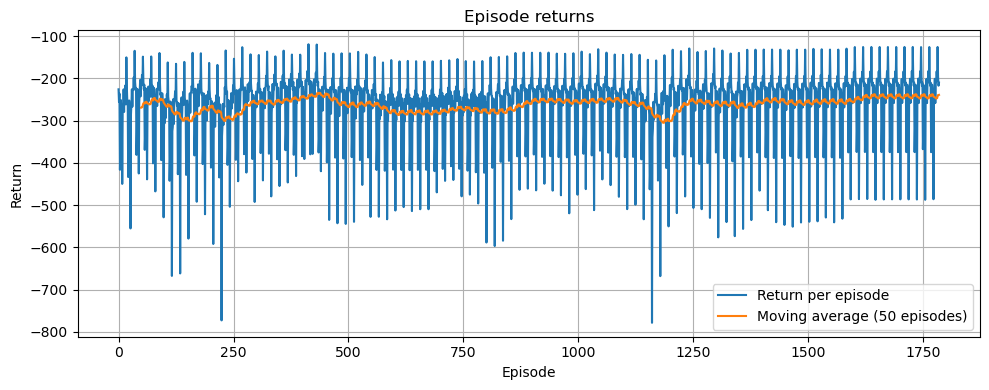

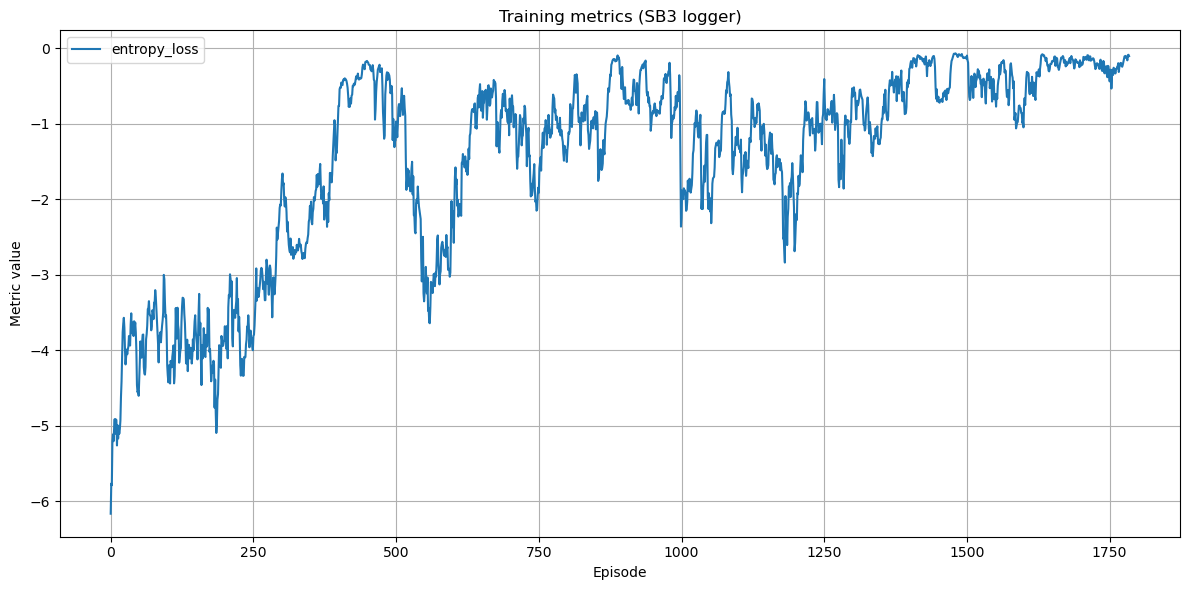

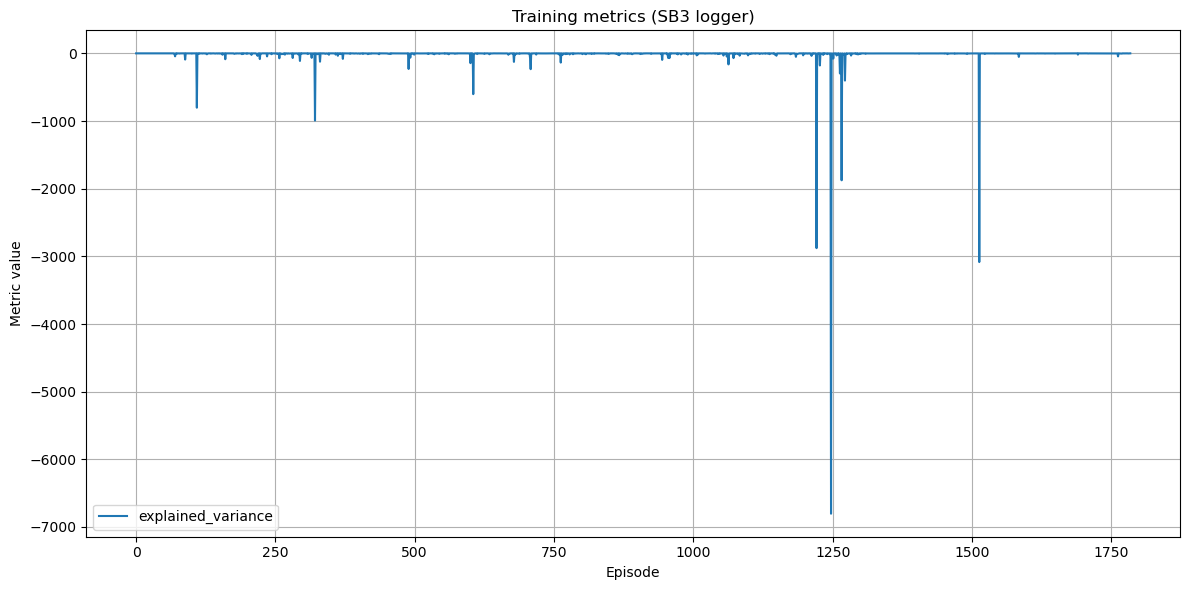

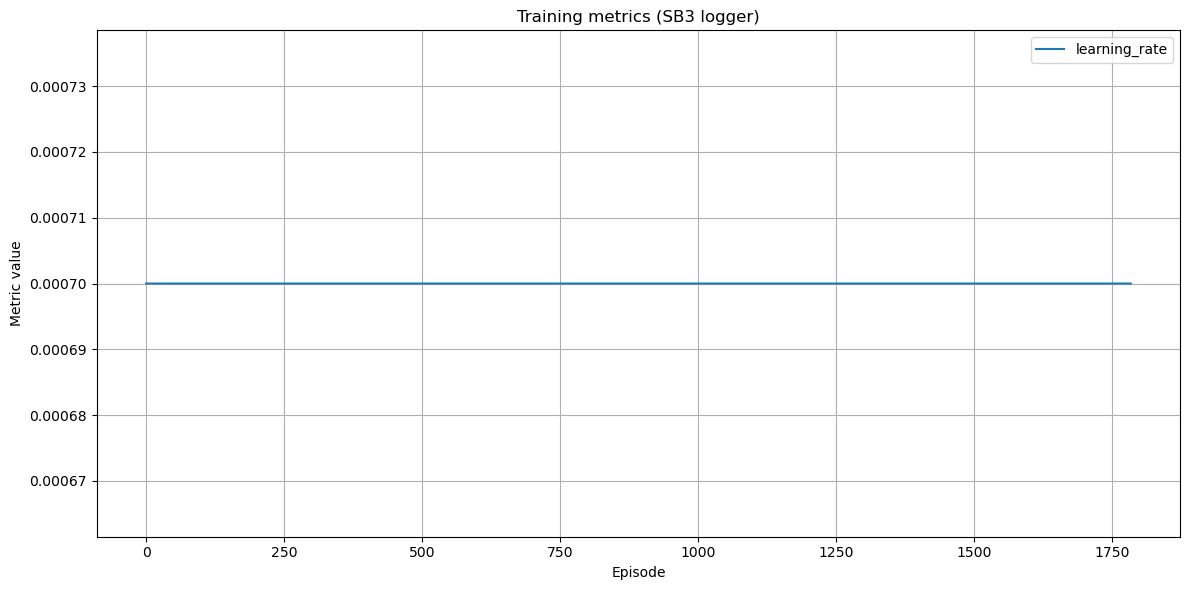

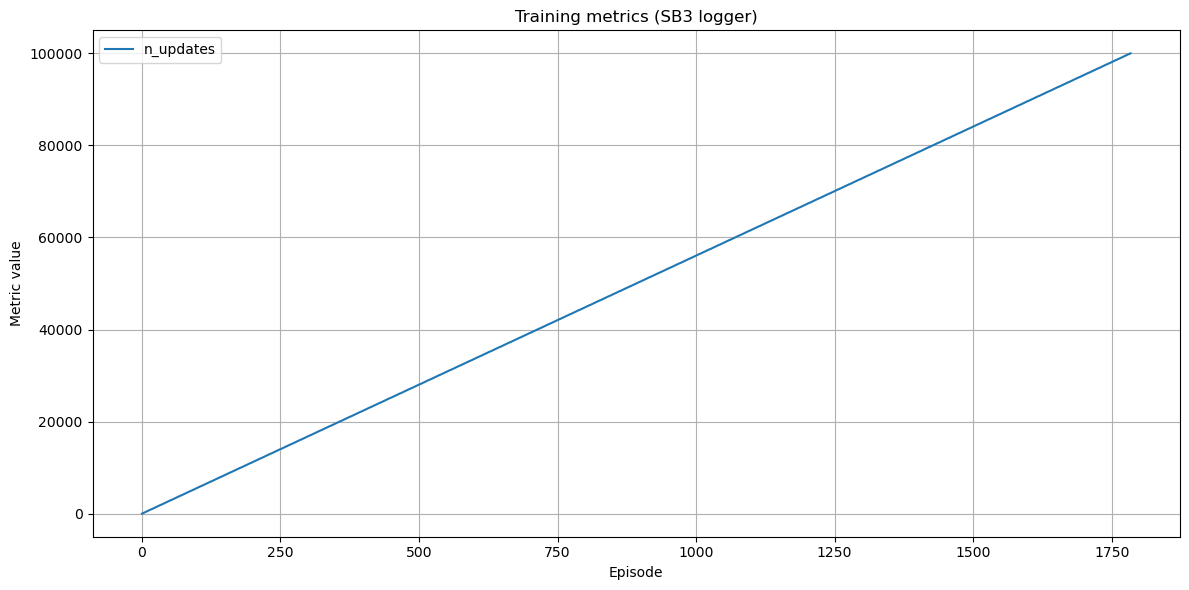

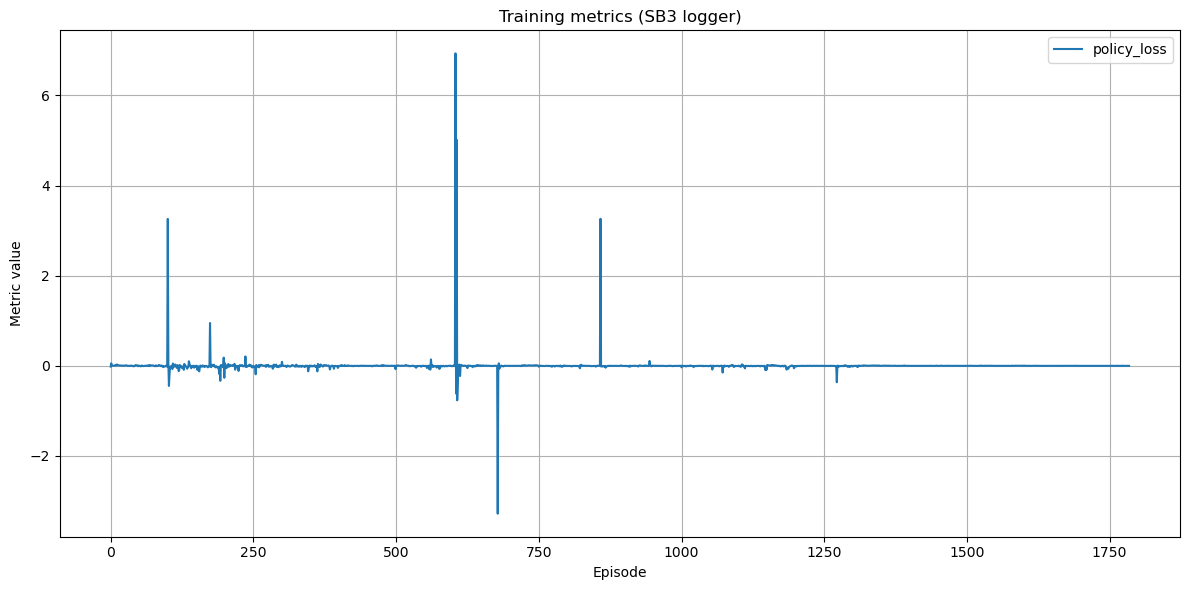

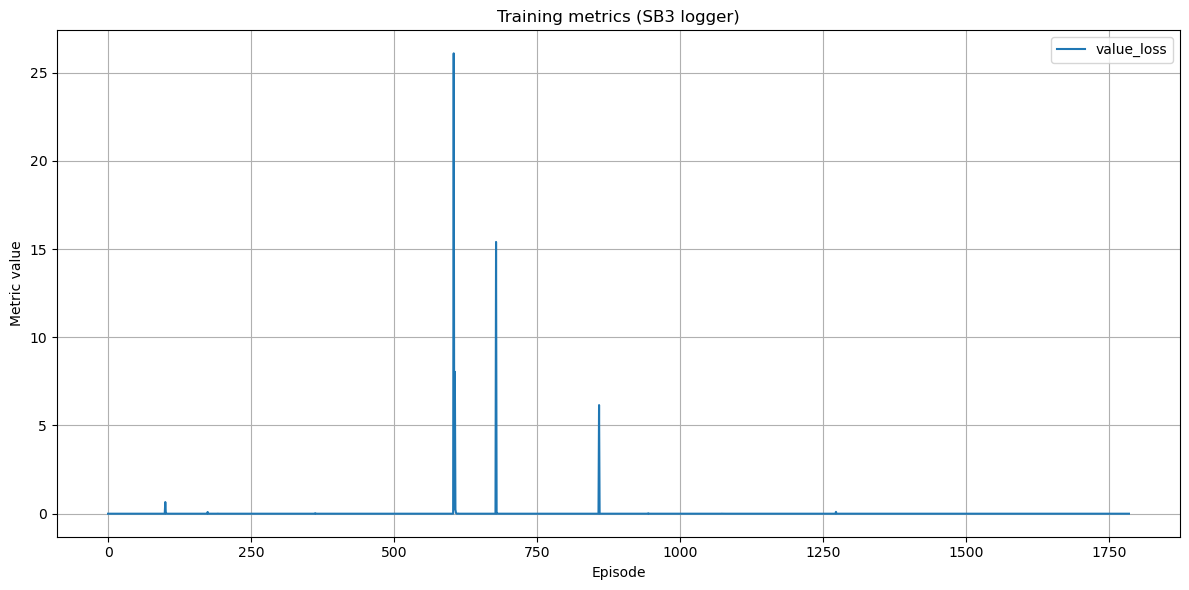

In [ ]:
plot_from_callback(metrics_cb, rolling_window=50)

In [23]:
# Save the trained model
model.save("trained_a2c_model")

print("✅ Model saved as 'trained_a2c_model.zip'")

✅ Model saved as 'trained_a2c_model.zip'


In [ ]:
# --- CELL 2 ---
# Load the model and run predictions WITHOUT an environment

from stable_baselines3 import A2C
import numpy as np

# Load the saved model
model = A2C.load("trained_a2c_model")
print("✅ Model loaded")

# Example observation: build it from your real observation dictionary
# Assuming you have:
obs_dict = {"T_out": 29, "Tin_Zone1": 25, "Tin_Zone2": 27, "Tin_Zone4": 26, "DNI": 120, "DH_Energy": 0, "DC_Energy": 500, "EL_Energy": 120, \
            "ShadeStatus_Zone1_Wall2": 0, "ShadeStatus_Zone1_Wall8": 0, "ShadeStatus_Zone1_Wall9": 0, "ShadeStatus_Zone2_Wall2": 0, "ShadeStatus_Zone2_wall3": 0, "ShadeStatus_Zone4_Wall2": 0}

# Convert obs_dict to a numpy array in the correct order
obs = np.array([obs_dict[n] for n in PARAMS["observation_names"]], dtype=np.float32)

# Predict action
action, _ = model.predict(obs, deterministic=True)
print("Predicted action:", action)


✅ Model loaded


NameError: name 'obs_dict' is not defined